In [140]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score

In [141]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [143]:
output_df = pd.read_csv(os.path.join(tableu_dir, 'bardis_ensemble_python_ver_100.csv'))
output_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id
0,1.000000,0.100000,1.000000e-02,0.001000,0.0,1.0
1,0.999951,0.100172,1.004647e-02,0.001101,0.2,1.0
2,0.999901,0.100345,1.009319e-02,0.001203,0.4,1.0
3,0.999849,0.100519,1.014014e-02,0.001304,0.6,1.0
4,0.999796,0.100694,1.018734e-02,0.001406,0.8,1.0
...,...,...,...,...,...,...
100095,0.000209,0.020162,9.452395e-07,1.143534,199.2,100.0
100096,0.000209,0.020162,9.224389e-07,1.143534,199.4,100.0
100097,0.000209,0.020162,9.001884e-07,1.143534,199.6,100.0
100098,0.000209,0.020162,8.784745e-07,1.143534,199.8,100.0


In [144]:
output_df.min()

Resources      3.688220e-06
Economy        2.822054e-04
Bureaucracy    9.963573e-18
Pollution      1.000000e-03
time           0.000000e+00
run_id         1.000000e+00
dtype: float64

In [145]:
fe = FeatureExtractor()
edau = EDAUtils()

# Time Series Clustering (Simple Approach)

## Create freatures df

In [146]:
transformed_output_df = output_df.groupby("run_id").apply(fe.extract_ts_features).reset_index()
transformed_output_df.head() 

/tmp/ipykernel_9114/2261743549.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transformed_output_df = output_df.groupby("run_id").apply(fe.extract_ts_features).reset_index()


,run_id,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,...,Pollution_max_200,Pollution_min_0,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200
0,1.0,0.013482,1.0,0.012950,67.206526,0.987050,0.000532,-0.986518,-0.000430,-0.000688,...,1.015576,0.001,0.016090,0.041817,0.126475,0.948833,1.014476,1.014943,1.015258,1.015576
1,2.0,0.000045,1.0,0.000045,51.009895,0.999955,0.000000,-0.999955,-0.002728,-0.003257,...,1.071811,0.001,0.038482,0.102376,0.221057,0.826416,1.059846,1.071326,1.071773,1.071811
2,3.0,0.010809,1.0,0.010809,70.233630,0.989191,0.000000,-0.989191,-0.001157,-0.001417,...,1.053842,0.001,0.032000,0.078121,0.166865,0.594159,1.034326,1.052673,1.053433,1.053842
3,4.0,0.016318,1.0,0.016318,74.944802,0.983682,0.000000,-0.983682,-0.002606,-0.003079,...,0.451646,0.001,0.038008,0.098219,0.182359,0.271299,0.347345,0.403643,0.436162,0.451646
4,5.0,0.000137,1.0,0.000137,64.836249,0.999863,0.000000,-0.999863,-0.001254,-0.001613,...,0.870236,0.001,0.022386,0.058255,0.123635,0.366662,0.834476,0.869299,0.870154,0.870236


In [147]:
transformed_output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 193 entries, run_id to Pollution_min_200
dtypes: float64(193)
memory usage: 150.9 KB


## Data Cleaning

- Drop duplicates?

In [148]:
transformed_output_df.isnull().sum().sort_values(ascending=False).head()


run_id             0
Resources_final    0
Resources_max      0
Resources_min      0
Resources_auc      0
dtype: int64

In [149]:
# Check for duplicates
transformed_output_df.duplicated().sum()

np.int64(0)

In [150]:
# Drop run_id to create features dataframe
features_df = transformed_output_df.drop(columns=["run_id"])
features_df.head()

,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,Resources_delta_15,...,Pollution_max_200,Pollution_min_0,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200
0,0.013482,1.0,0.012950,67.206526,0.987050,0.000532,-0.986518,-0.000430,-0.000688,-0.001005,...,1.015576,0.001,0.016090,0.041817,0.126475,0.948833,1.014476,1.014943,1.015258,1.015576
1,0.000045,1.0,0.000045,51.009895,0.999955,0.000000,-0.999955,-0.002728,-0.003257,-0.003913,...,1.071811,0.001,0.038482,0.102376,0.221057,0.826416,1.059846,1.071326,1.071773,1.071811
2,0.010809,1.0,0.010809,70.233630,0.989191,0.000000,-0.989191,-0.001157,-0.001417,-0.001728,...,1.053842,0.001,0.032000,0.078121,0.166865,0.594159,1.034326,1.052673,1.053433,1.053842
3,0.016318,1.0,0.016318,74.944802,0.983682,0.000000,-0.983682,-0.002606,-0.003079,-0.003615,...,0.451646,0.001,0.038008,0.098219,0.182359,0.271299,0.347345,0.403643,0.436162,0.451646
4,0.000137,1.0,0.000137,64.836249,0.999863,0.000000,-0.999863,-0.001254,-0.001613,-0.002043,...,0.870236,0.001,0.022386,0.058255,0.123635,0.366662,0.834476,0.869299,0.870154,0.870236


## EDA

In [151]:
features_df.describe()

,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,Resources_delta_15,...,Pollution_max_200,Pollution_min_0,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.032213,1.000023,0.031830,68.786965,0.968194,0.000383,-0.967787,-0.001399,-0.001780,-0.002263,...,0.973625,1.000000e-03,0.030015,0.080325,0.315125,0.692332,0.871890,0.946230,0.967348,0.973625
std,0.062762,0.000185,0.062631,21.863823,0.062619,0.001166,0.062762,0.000661,0.000794,0.001006,...,0.203035,2.179328e-19,0.008356,0.025631,0.274230,0.370020,0.290830,0.231536,0.212540,0.203035
min,0.000004,1.000000,0.000004,38.937757,0.622108,0.000000,-0.999996,-0.002728,-0.003304,-0.004519,...,0.439614,1.000000e-03,0.015527,0.037494,0.076753,0.136426,0.265585,0.350320,0.402456,0.439614
25%,0.000800,1.000000,0.000800,50.271104,0.965858,0.000000,-0.999200,-0.001834,-0.002308,-0.002961,...,0.912793,1.000000e-03,0.023093,0.060173,0.138296,0.286438,0.673358,0.883412,0.912017,0.912793
50%,0.005337,1.000000,0.004842,64.854883,0.995158,0.000000,-0.994663,-0.001369,-0.001804,-0.002272,...,1.048114,1.000000e-03,0.029295,0.077432,0.205655,0.799600,0.968698,1.026865,1.047385,1.048114
75%,0.036376,1.000000,0.034142,83.662554,0.999200,0.000078,-0.963624,-0.000972,-0.001238,-0.001557,...,1.122832,1.000000e-03,0.037274,0.096745,0.389292,1.063767,1.106202,1.122744,1.122800,1.122832
max,0.377892,1.001778,0.377892,139.780020,0.999996,0.008567,-0.622108,0.000197,0.000035,-0.000164,...,1.190380,1.000000e-03,0.044641,0.157471,1.096009,1.158873,1.182790,1.190058,1.190361,1.190380


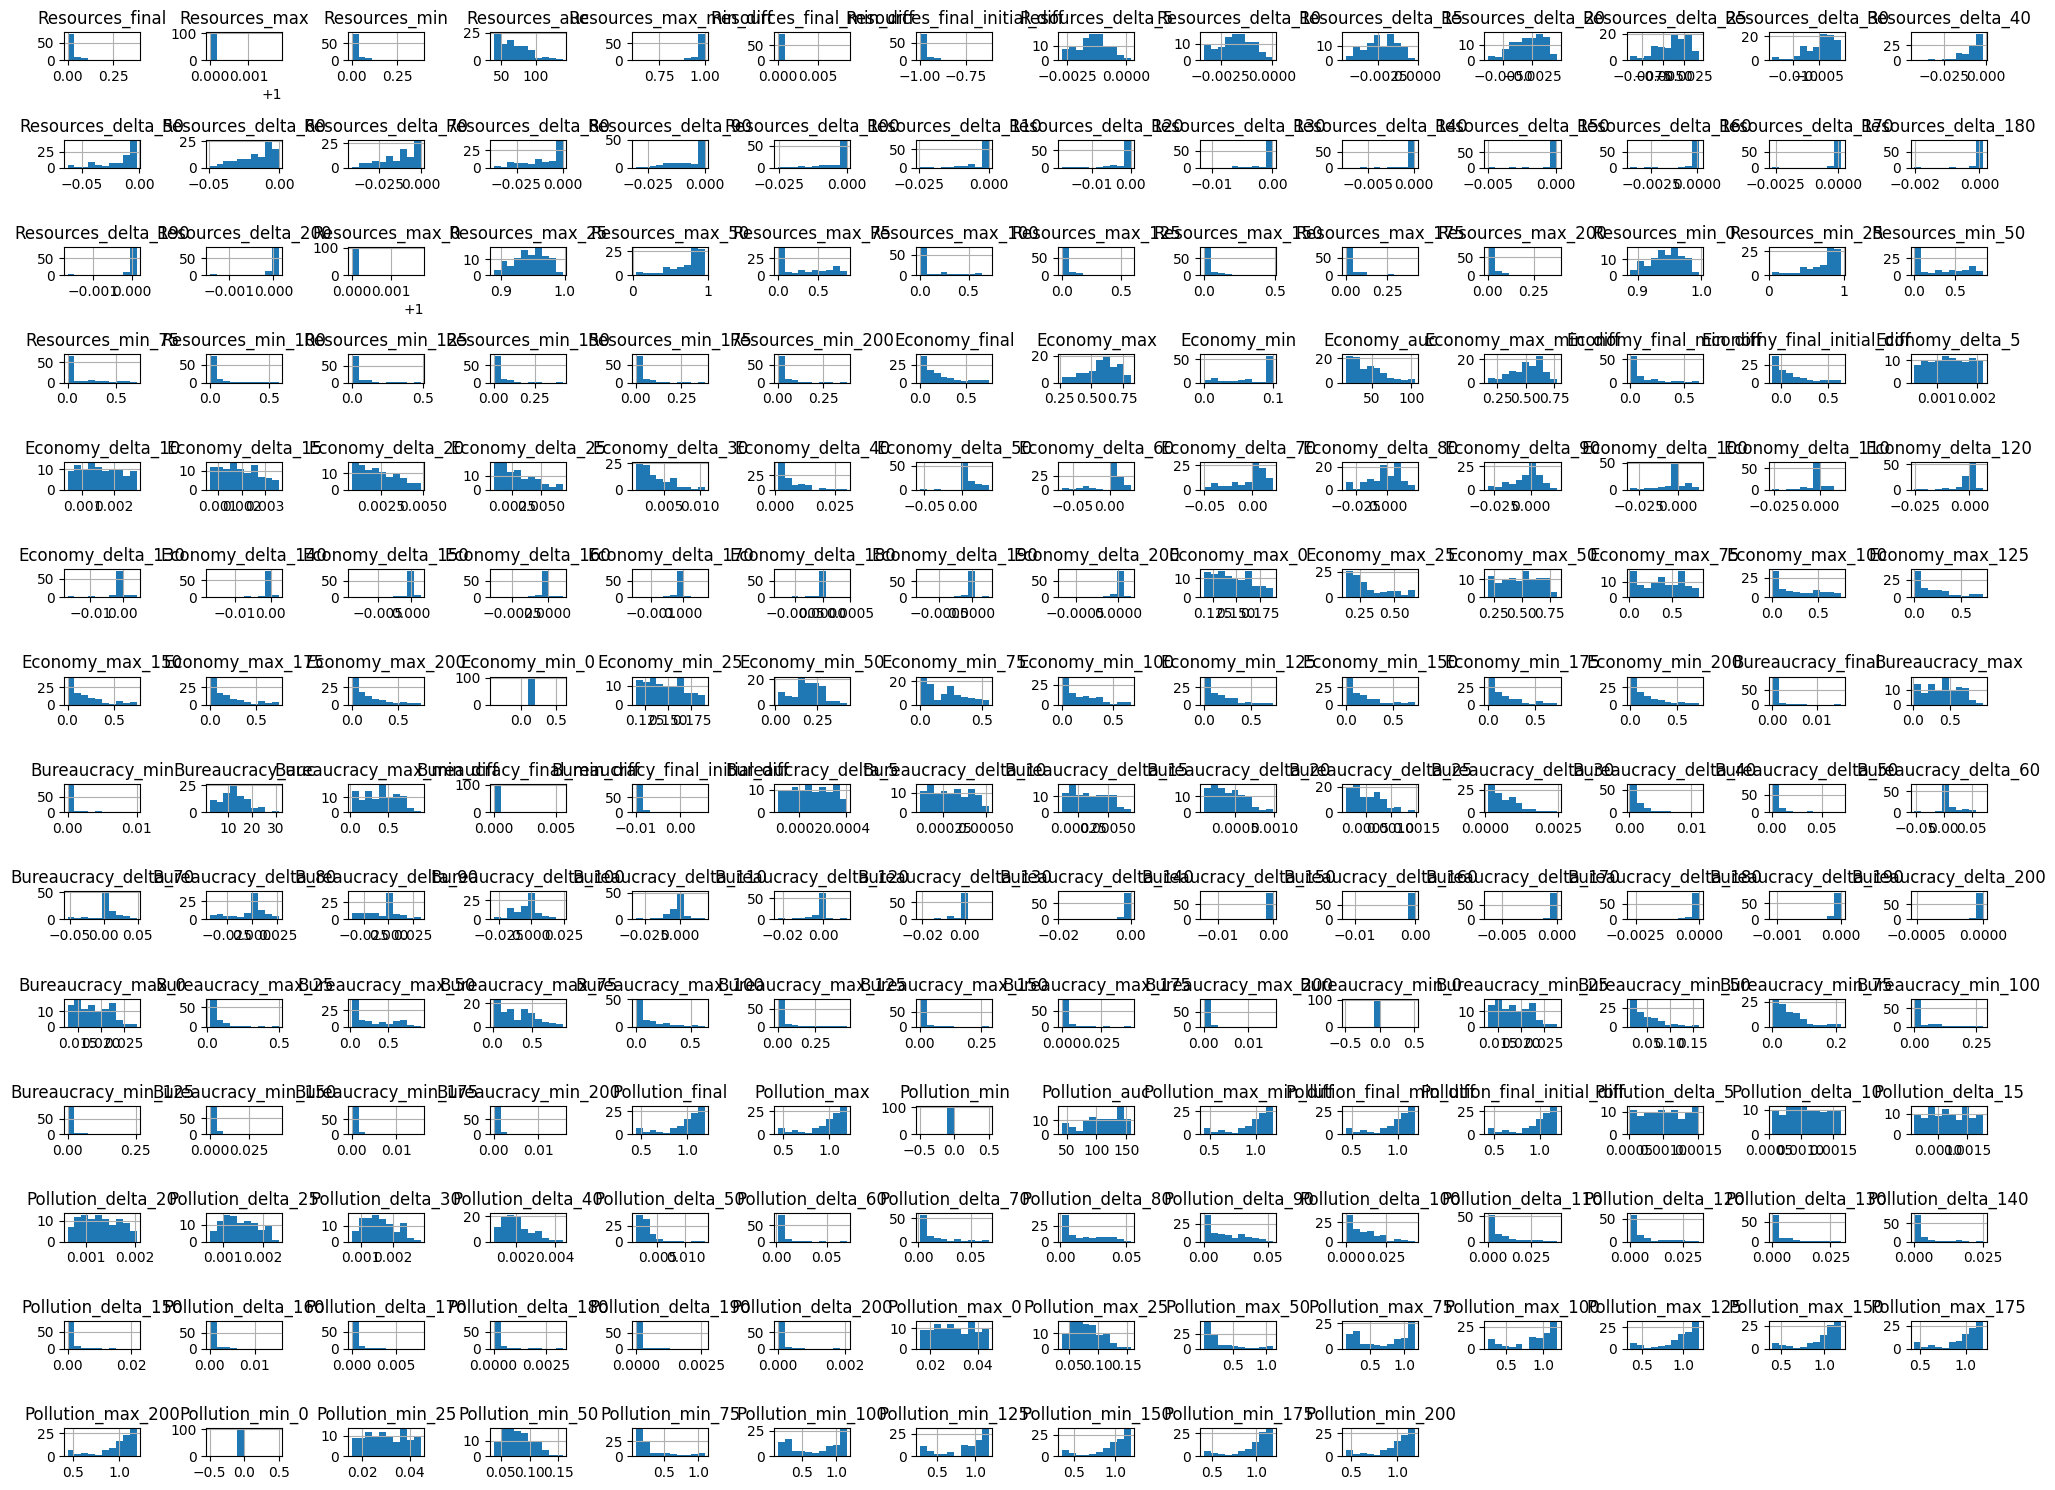

In [152]:
edau.plot_histograms(features_df)

In [153]:
# # Correlation heatmap to inspect relationships between features
# plt.figure(figsize=(40, 20))
# sns.heatmap(features_df.corr(), annot=True, cmap="coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

In [154]:
# Calculate skewness for numeric features in the DataFrame
skewness = features_df.skew(numeric_only=True)
# print("Skewness of features:\n", skewness)

# Define a threshold for high skewness, e.g., absolute skewness > 1
threshold = 1
skewed_features = skewness[abs(skewness) > threshold].index.tolist()
print("Skewed features:", skewed_features)


Skewed features: ['Resources_final', 'Resources_max', 'Resources_min', 'Resources_max_min_diff', 'Resources_final_min_diff', 'Resources_final_initial_diff', 'Resources_delta_30', 'Resources_delta_40', 'Resources_delta_50', 'Resources_delta_100', 'Resources_delta_110', 'Resources_delta_120', 'Resources_delta_130', 'Resources_delta_140', 'Resources_delta_150', 'Resources_delta_160', 'Resources_delta_170', 'Resources_delta_180', 'Resources_delta_190', 'Resources_delta_200', 'Resources_max_0', 'Resources_max_50', 'Resources_max_100', 'Resources_max_125', 'Resources_max_150', 'Resources_max_175', 'Resources_max_200', 'Resources_min_25', 'Resources_min_75', 'Resources_min_100', 'Resources_min_125', 'Resources_min_150', 'Resources_min_175', 'Resources_min_200', 'Economy_final', 'Economy_final_min_diff', 'Economy_final_initial_diff', 'Economy_delta_30', 'Economy_delta_40', 'Economy_delta_50', 'Economy_delta_60', 'Economy_delta_100', 'Economy_delta_110', 'Economy_delta_120', 'Economy_delta_130'

In [155]:
# features_df_no_skew = features_df.drop(columns=skewed_features)

In [156]:
# Histograms for each numeric feature
# edau.plot_histograms(features_df_no_skew)

In [157]:
# Log-transform the skewed features
features_df_log = features_df.copy()

# TODO: Only to skewed features or to all features?
features_df_log = edau.apply_log_transform(features_df_log, skewed_features)

Applied natural log to column: Resources_final
Applied natural log to column: Resources_max
Applied natural log to column: Resources_min
Applied natural log to column: Resources_max_min_diff
Applied log1p with offset 1.0 to column: Resources_final_min_diff
Applied log1p with offset 1.9999962409472753 to column: Resources_final_initial_diff
Applied log1p with offset 1.013893404531185 to column: Resources_delta_30
Applied log1p with offset 1.043400327718163 to column: Resources_delta_40
Applied log1p with offset 1.062114637724328 to column: Resources_delta_50
Applied log1p with offset 1.0256112937113975 to column: Resources_delta_100
Applied log1p with offset 1.024577593278575 to column: Resources_delta_110
Applied log1p with offset 1.0178167181987223 to column: Resources_delta_120
Applied log1p with offset 1.0113090954791317 to column: Resources_delta_130
Applied log1p with offset 1.0074341499036465 to column: Resources_delta_140
Applied log1p with offset 1.0050223501356512 to column: R

In [158]:
# edau.plot_histograms(features_df_log)

## Preprocess data

- Drop redoundant variables?
- Drop vars that have very thight distributions?

In [159]:
# Scale the features
# X = features_df.drop(columns=["run_id"])
X = features_df_log.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled.shape

(100, 192)

Number of components selected: 8


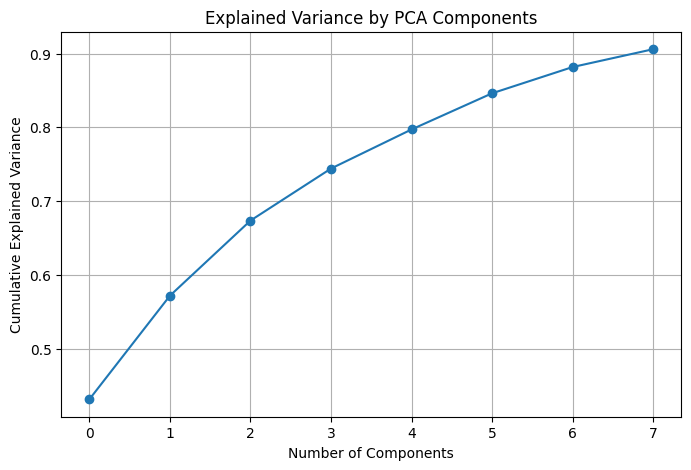

In [160]:
# Retain enough components to explain 90% of the variance
pca = PCA(n_components=0.9, random_state=42)
df_pca = pca.fit_transform(X_scaled)



print("Number of components selected:", pca.n_components_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

Explained variance ratio for all components: [4.31504148e-01 1.40352154e-01 1.01760758e-01 7.04974523e-02
 5.29868286e-02 4.89920910e-02 3.55907319e-02 2.41543536e-02
 1.69288793e-02 1.47588988e-02 1.31426368e-02 1.15341272e-02
 6.43217719e-03 5.45164157e-03 4.54560208e-03 3.20897926e-03
 3.03236038e-03 2.52495792e-03 2.01307560e-03 1.66454823e-03
 1.45484439e-03 1.03390866e-03 8.58225996e-04 7.53157513e-04
 7.25118085e-04 5.40875377e-04 4.79725597e-04 4.52100299e-04
 3.96605798e-04 3.65538079e-04 2.99659983e-04 2.33307537e-04
 2.05223601e-04 1.65051681e-04 1.55177923e-04 1.29530955e-04
 9.48289619e-05 8.56213226e-05 7.03097279e-05 5.91025860e-05
 5.59698796e-05 4.18388119e-05 3.53434369e-05 3.25079618e-05
 2.97121756e-05 2.31721390e-05 2.15784366e-05 1.86907479e-05
 1.56776596e-05 1.24706603e-05 1.21173103e-05 9.43512862e-06
 8.36443598e-06 7.24228835e-06 6.18500029e-06 5.08238350e-06
 4.81399990e-06 3.68907774e-06 3.15281076e-06 2.96048071e-06
 2.39707231e-06 2.14864188e-06 2.0788819

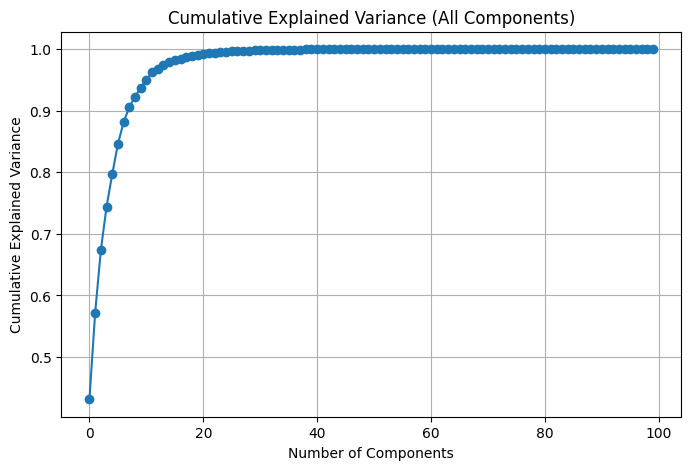

In [161]:
pca_full = PCA(n_components=None, random_state=42)
df_pca_full = pca_full.fit_transform(X_scaled)
print("Explained variance ratio for all components:", pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance (All Components)")
plt.grid(True)
plt.show()


In [162]:
# # Each row = feature, each column = principal component
# loadings = pd.DataFrame(
#     pca_full.components_.T,  # Transpose to have features as rows
#     index=features_df_log.columns,  # Feature names
#     columns=[f'PC{i+1}' for i in range(pca_full.n_components_)]
# )

# # Select top N components to visualize
# top_n = 5
# plt.figure(figsize=(12, min(0.5 * len(loadings), 12)))
# sns.heatmap(loadings.iloc[:, :top_n], annot=True, cmap='coolwarm', center=0)
# plt.title(f"PCA Loadings (Top {top_n} Components)")
# plt.xlabel("Principal Components")
# plt.ylabel("Original Features")
# plt.tight_layout()
# plt.show()

# # Create a dataframe that shows the relationship between the components and the original variables
# df_pca_comp = pd.DataFrame(data = pca.components_,
#                            columns = features_df_log.columns)

# # Create the Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
# plt.figure(figsize=(70,10))
# sns.heatmap(df_pca_comp,
#             vmin = -1, 
#             vmax = 1,
#             cmap = 'RdBu',
#             annot = True)

# plt.title('Components vs Original Features',fontsize = 14)
# plt.show()

In [163]:
np.cumsum(pca.explained_variance_ratio_)

array([0.43150415, 0.5718563 , 0.67361706, 0.74411451, 0.79710134,
       0.84609343, 0.88168416, 0.90583852])

In [164]:
df_pca.shape

(100, 8)

In [165]:
rows_n = df_pca.shape[0]

## Train Models

### Visualization Functions

### K means

In [166]:
def plot_clusters(df, clusters, principal_component_x=0, principal_component_y=1, principal_component_z=None):
    """
    Plots clusters using 2D or 3D PCA-transformed data.

    Parameters:
    - df: ndarray or DataFrame with PCA components
    - clusters: cluster labels
    - principal_component_x, principal_component_y: indexes of PCA components for 2D plot
    - principal_component_z: index of third component for 3D plot (optional)
    """
    
    if principal_component_z is not None and df.shape[1] > principal_component_z:
        # 3D Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            df[:, principal_component_x], 
            df[:, principal_component_y], 
            df[:, principal_component_z], 
            c=clusters, cmap="plasma", edgecolor='k'
        )
        ax.set_xlabel(f"Principal Component {principal_component_x + 1}")
        ax.set_ylabel(f"Principal Component {principal_component_y + 1}")
        ax.set_zlabel(f"Principal Component {principal_component_z + 1}")
        ax.set_title("Cluster Visualization (PCA 3D)")

        # Create legend
        unique_clusters = np.unique(clusters)
        handles = [
            mpatches.Patch(color=scatter.cmap(scatter.norm(cl)), label=f"Cluster {cl}")
            for cl in unique_clusters
        ]
        ax.legend(handles=handles, title="Cluster Label", loc="upper left")
        plt.show()

    elif df.shape[1] >= 2:
        # 2D Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            df[:, principal_component_x], 
            df[:, principal_component_y], 
            c=clusters, cmap="plasma", edgecolor='k'
        )
        plt.xlabel(f"Principal Component {principal_component_x + 1}")
        plt.ylabel(f"Principal Component {principal_component_y + 1}")
        plt.title("Cluster Visualization (PCA 2D)")
        plt.grid(True)

        unique_clusters = np.unique(clusters)
        handles = [
            mpatches.Patch(color=scatter.cmap(scatter.norm(cl)), label=f"Cluster {cl}")
            for cl in unique_clusters
        ]
        plt.legend(handles=handles, title="Cluster Label", loc="best")
        plt.show()
    
    else:
        print("Not enough components to visualize clusters.")
        
    return None


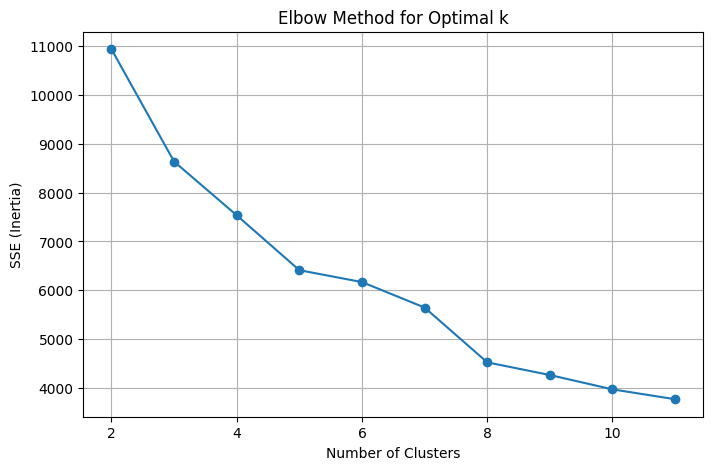

In [167]:
sse = []
k_range = range(2, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_range), sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()


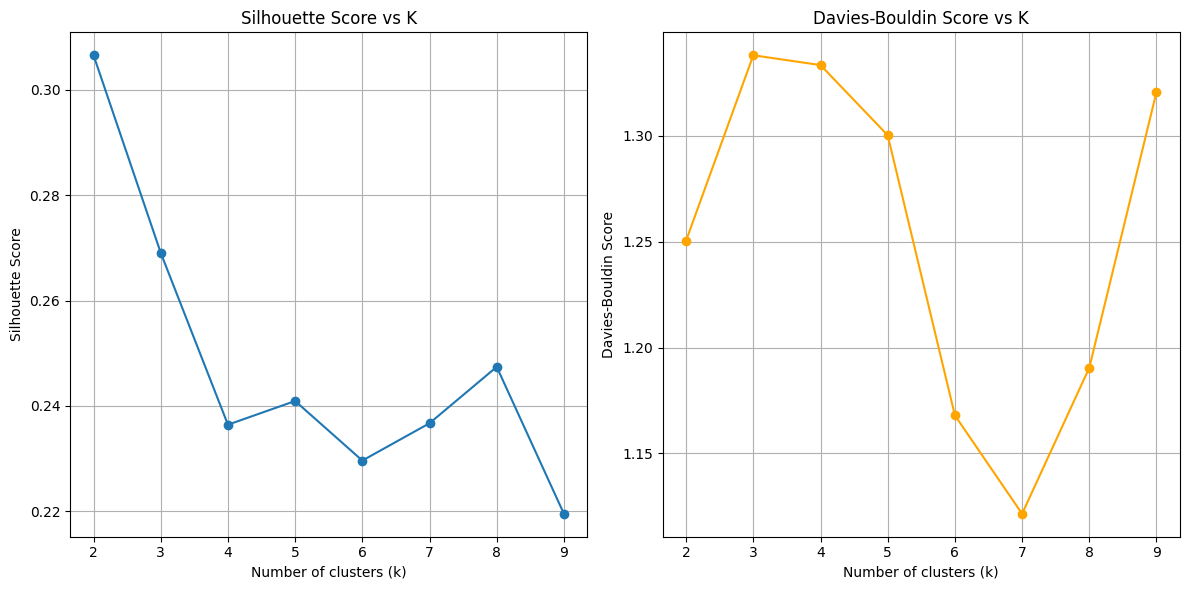

In [168]:
# Define the range of k (number of clusters) to test
k_values = range(2, 10) 

results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(df_pca)
    
    # Evaluate scores
    silhouette = silhouette_score(df_pca, labels)
    dbi = davies_bouldin_score(df_pca, labels)

    results.append({
        "k": k,
        "silhouette_score": silhouette,
        "davies_bouldin": dbi
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df["k"], results_df["silhouette_score"], marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df["k"], results_df["davies_bouldin"], marker='o', color='orange')
plt.title("Davies-Bouldin Score vs K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies-Bouldin Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [190]:
k = 4 # Adjust this value based on the elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(df_pca)

# Evaluate clustering quality
sil_score = silhouette_score(df_pca, clusters_kmeans)
print("Silhouette Score:", sil_score)

dbi = davies_bouldin_score(df_pca, clusters_kmeans)
print(f"Davies-Bouldin Score: {dbi:.3f}")

Silhouette Score: 0.2364253823799783
Davies-Bouldin Score: 1.333


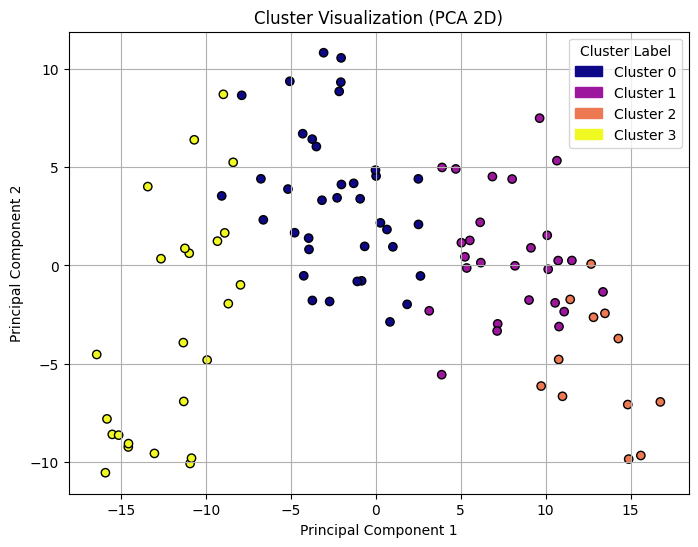

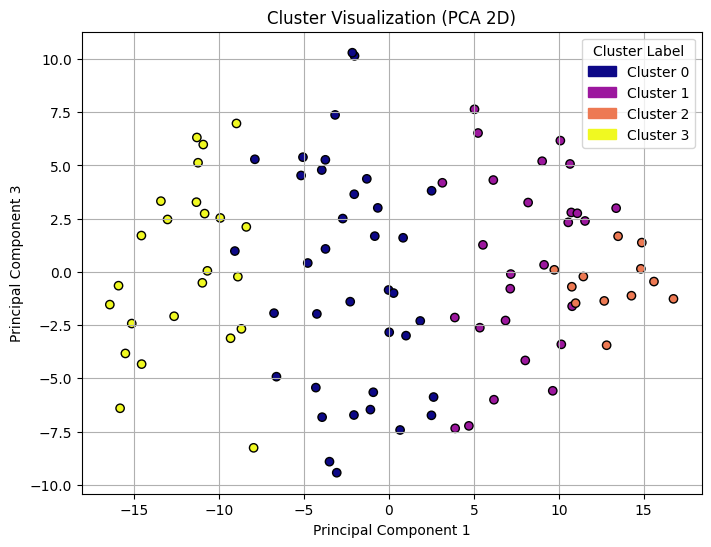

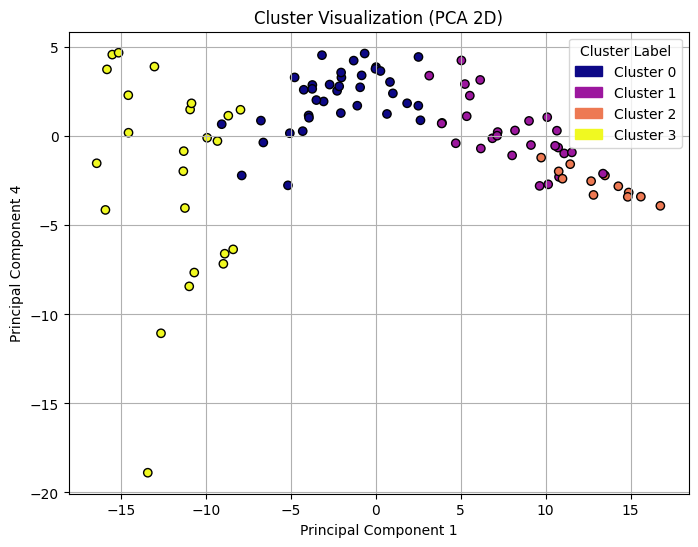

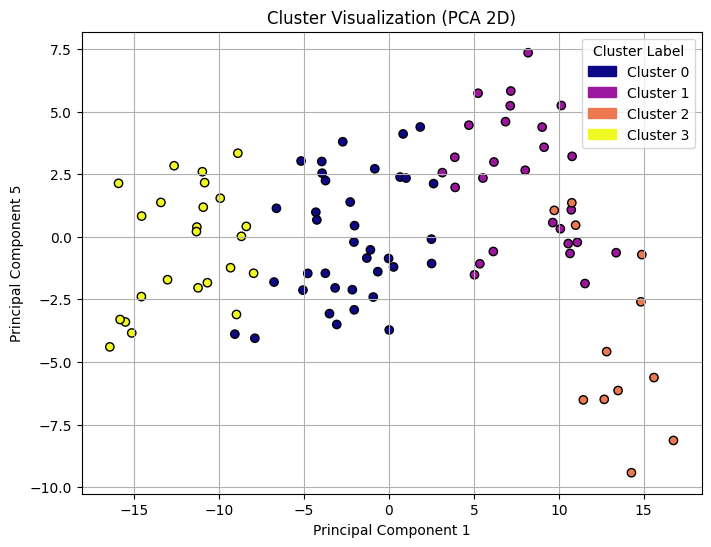

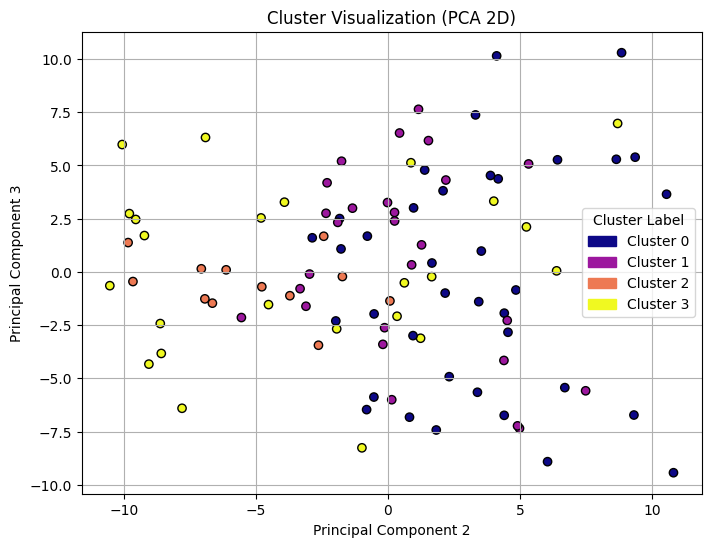

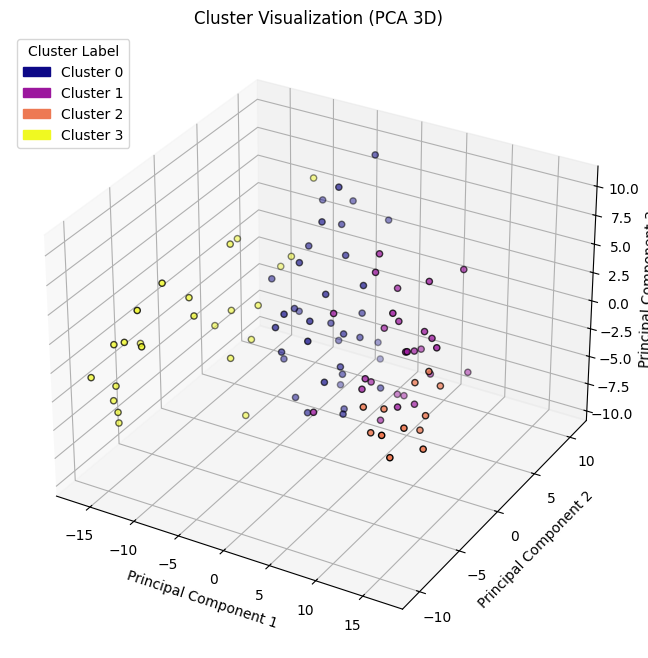

In [191]:
# Plot KMeans clusters from different PCA components

plot_clusters(df_pca, clusters_kmeans)
plot_clusters(df_pca, clusters_kmeans, 0, 2)
plot_clusters(df_pca, clusters_kmeans, 0, 3)
plot_clusters(df_pca, clusters_kmeans, 0 ,4)
plot_clusters(df_pca, clusters_kmeans, 1 ,2)
plot_clusters(df_pca, clusters_kmeans, 0, 1, 2)

### DBSCAN

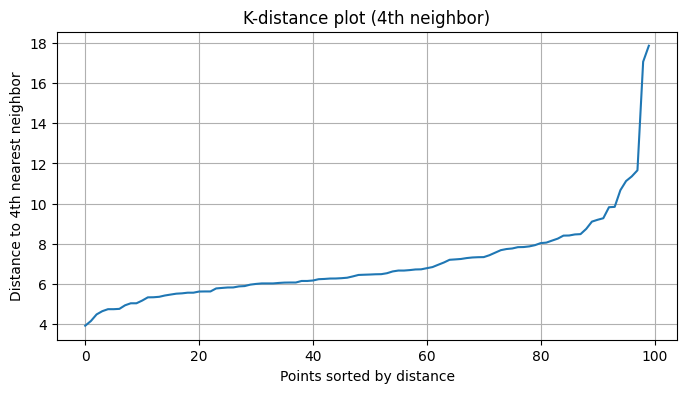

In [192]:
# Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, 4])  # 4th nearest neighbor distance
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-distance plot (4th neighbor)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 4th nearest neighbor")
plt.grid(True)
plt.show()


In [193]:
# Try some values first
dbscan = DBSCAN(eps=7, min_samples=5)  # Adjust eps based on elbow plot
dbscan.fit(df_pca)

# Add cluster labels to original dataframe
labels = dbscan.labels_  # -1 means noise


In [194]:
# # Exclude noise points
# mask = labels != -1
# if len(set(labels)) > 1 and sum(mask) > 1:
#     score = silhouette_score(df_pca[mask], labels[mask])
#     print(f"Silhouette Score: {score:.3f}")
# else:
#     print("Not enough clusters (or too much noise) to compute silhouette score.")

    

# if len(set(labels)) > 1 and sum(mask) > 1:
#     dbi = davies_bouldin_score(df_pca[mask], labels[mask])
#     print(f"Davies-Bouldin Index: {dbi:.3f}")



In [195]:

# Define the eps range and min_samples
eps_values = np.arange(0.5, 15.0, 0.1)  # Adjust based on your k-distance plot
min_samples = 5

results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(df_pca)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Mask for non-noise points
    mask = labels != -1
    
    # Only evaluate if we have at least 2 clusters and some valid points
    if n_clusters >= 2 and np.sum(mask) > 10:
        silhouette = silhouette_score(df_pca[mask], labels[mask])
        dbi = davies_bouldin_score(df_pca[mask], labels[mask])
    else:
        silhouette = np.nan
        dbi = np.nan
    
    results.append({
        "eps": eps,
        "clusters": n_clusters,
        "noise_points": n_noise,
        "silhouette_score": silhouette,
        "davies_bouldin": dbi
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

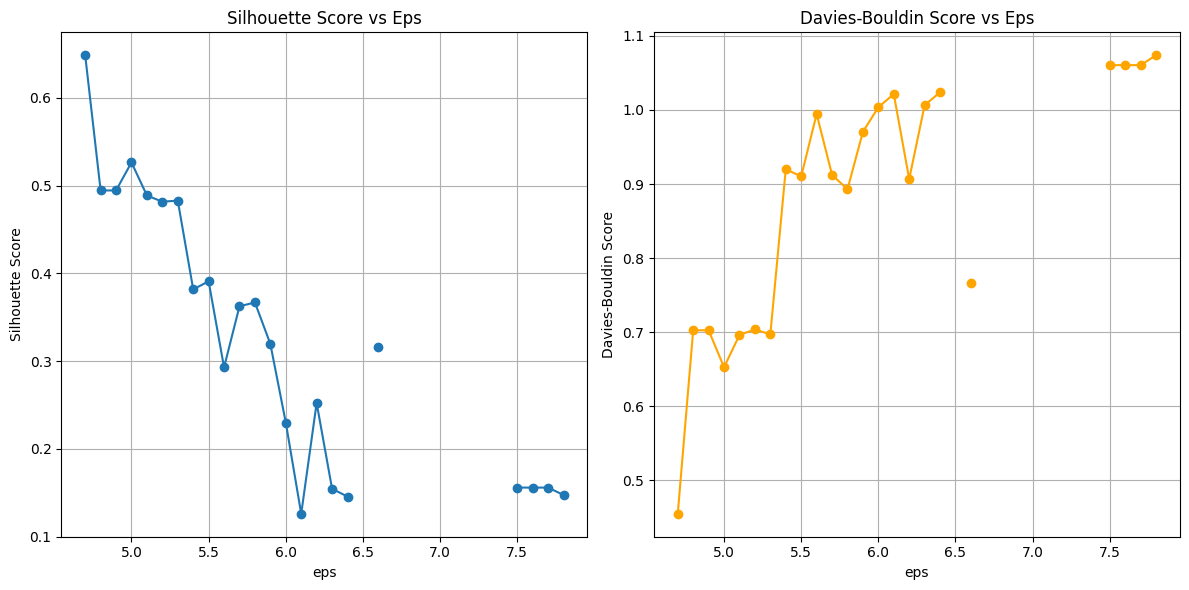

In [196]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df["eps"], results_df["silhouette_score"], marker='o')
plt.title("Silhouette Score vs Eps")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df["eps"], results_df["davies_bouldin"], marker='o', color='orange')
plt.title("Davies-Bouldin Score vs Eps")
plt.xlabel("eps")
plt.ylabel("Davies-Bouldin Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [197]:
eps = 2.2

dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(df_pca)

# Add cluster labels to original dataframe
labels = dbscan.labels_  # -1 means noise


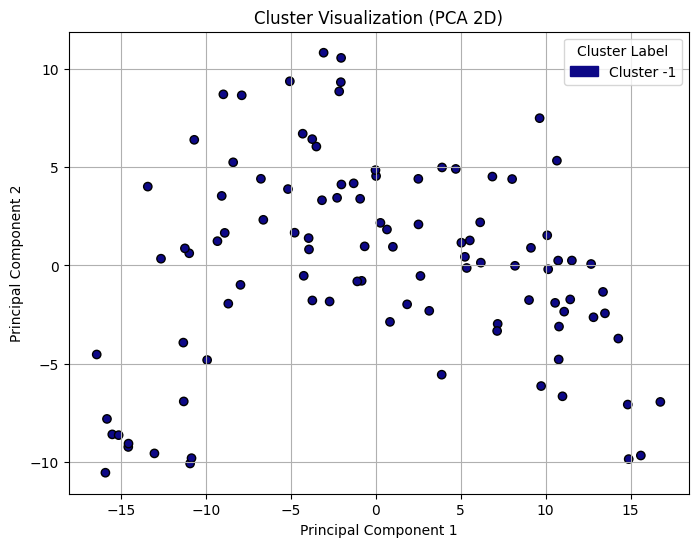

In [198]:
# Plot DBSCAN clusters from different PCA components
plot_clusters(df_pca, labels)

## Add Labels to Output Df

In [199]:
transformed_output_df.head()

,run_id,Resources_final,Resources_max,Resources_min,Resources_auc,Resources_max_min_diff,Resources_final_min_diff,Resources_final_initial_diff,Resources_delta_5,Resources_delta_10,...,Pollution_min_25,Pollution_min_50,Pollution_min_75,Pollution_min_100,Pollution_min_125,Pollution_min_150,Pollution_min_175,Pollution_min_200,kmeans_cluster_id,dbscan_cluster_id
0,1.0,0.013482,1.0,0.012950,67.206526,0.987050,0.000532,-0.986518,-0.000430,-0.000688,...,0.016090,0.041817,0.126475,0.948833,1.014476,1.014943,1.015258,1.015576,4,-1
1,2.0,0.000045,1.0,0.000045,51.009895,0.999955,0.000000,-0.999955,-0.002728,-0.003257,...,0.038482,0.102376,0.221057,0.826416,1.059846,1.071326,1.071773,1.071811,1,-1
2,3.0,0.010809,1.0,0.010809,70.233630,0.989191,0.000000,-0.989191,-0.001157,-0.001417,...,0.032000,0.078121,0.166865,0.594159,1.034326,1.052673,1.053433,1.053842,4,-1
3,4.0,0.016318,1.0,0.016318,74.944802,0.983682,0.000000,-0.983682,-0.002606,-0.003079,...,0.038008,0.098219,0.182359,0.271299,0.347345,0.403643,0.436162,0.451646,3,-1
4,5.0,0.000137,1.0,0.000137,64.836249,0.999863,0.000000,-0.999863,-0.001254,-0.001613,...,0.022386,0.058255,0.123635,0.366662,0.834476,0.869299,0.870154,0.870236,0,-1


In [200]:
# Add cluster labels to the transformed DataFrame
transformed_output_df["kmeans_cluster_id"] = clusters_kmeans
transformed_output_df["dbscan_cluster_id"] = labels
# Save the transformed DataFrame with cluster labels
transformed_output_df.to_csv(os.path.join(porcessed_data_dir, f'transformed_output_with_{k}_clusters.csv'), index=False)

# Create a new df to map run_id to cluster_id
cluster_mapping_df = transformed_output_df[["run_id", "kmeans_cluster_id", "dbscan_cluster_id"]]

cluster_mapping_df

,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.0,0,-1
1,2.0,1,-1
2,3.0,0,-1
3,4.0,3,-1
4,5.0,0,-1
...,...,...,...
95,96.0,1,-1
96,97.0,0,-1
97,98.0,0,-1
98,99.0,1,-1


In [201]:
# Check for duplicates in the mapping DataFrame
print('duplicates: ', cluster_mapping_df.duplicated().sum())
# Check for null values in the mapping DataFrame
print('null values: \n', cluster_mapping_df.isnull().sum())

duplicates:  0
null values: 
 run_id               0
kmeans_cluster_id    0
dbscan_cluster_id    0
dtype: int64


In [202]:
output_df.head()

,Resources,Economy,Bureaucracy,Pollution,time,run_id
0,1.000000,0.100000,0.010000,0.001000,0.0,1.0
1,0.999951,0.100172,0.010046,0.001101,0.2,1.0
2,0.999901,0.100345,0.010093,0.001203,0.4,1.0
3,0.999849,0.100519,0.010140,0.001304,0.6,1.0
4,0.999796,0.100694,0.010187,0.001406,0.8,1.0


In [203]:
# Merge the cluster mapping DataFrame with the original output DataFrame
output_df_with_labels = output_df.merge(cluster_mapping_df, on="run_id", how="left")
output_df_with_labels.head()

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,0.100000,0.010000,0.001000,0.0,1.0,0,-1
1,0.999951,0.100172,0.010046,0.001101,0.2,1.0,0,-1
2,0.999901,0.100345,0.010093,0.001203,0.4,1.0,0,-1
3,0.999849,0.100519,0.010140,0.001304,0.6,1.0,0,-1
4,0.999796,0.100694,0.010187,0.001406,0.8,1.0,0,-1


In [204]:
output_df_with_labels.tail()

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
100095,0.000209,0.020162,9.452395e-07,1.143534,199.2,100.0,1,-1
100096,0.000209,0.020162,9.224389e-07,1.143534,199.4,100.0,1,-1
100097,0.000209,0.020162,9.001884e-07,1.143534,199.6,100.0,1,-1
100098,0.000209,0.020162,8.784745e-07,1.143534,199.8,100.0,1,-1
100099,0.000209,0.020162,8.572844e-07,1.143534,200.0,100.0,1,-1


In [205]:
# Sanity check that each run id is only in one cluster
output_df_with_labels.groupby("run_id")["kmeans_cluster_id"].nunique().value_counts()

kmeans_cluster_id
1    100
Name: count, dtype: int64

In [206]:

# File name for the processed data
processed_data_file = os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{rows_n}_k{k}_eps{eps}.csv')
# Save the output DataFrame with cluster labels
output_df_with_labels.to_csv(processed_data_file, index=False)

print(f"Processed data saved to {processed_data_file}")


Processed data saved to /home/tony-ubuntu/decision_sciences/looking_back_to_look_forward/results_analysis/processed_data/bardis_ensemble_python_ver_100_k4_eps2.2.csv
